In [1]:
%pylab inline
import tifffile
import seaborn as sns
sns.set_style("white")
import scipy.optimize
import scipy.constants
import scipy.special
gaussian = lambda x, A0, x0, sigma: A0*np.exp((-(x-x0)**2)/(2.*sigma**2))
gaussians = lambda x, A0s, x0s, sigmas: np.asarray([gaussian(x=x, A0=_A0, x0=_x0, sigma=_sigma) for _A0, _x0, _sigma in zip(A0s, x0s, sigmas)]).sum(axis=0)
gaussians_equal_sigmas = lambda x, A0s, x0s, sigma: np.asarray([gaussian(x=x, A0=_A0, x0=_x0, sigma=sigma) for _i, (_A0, _x0) in enumerate(zip(A0s, x0s))]).sum(axis=0)


Populating the interactive namespace from numpy and matplotlib


In [2]:
I = array(tifffile.imread("./em_data/rubisco_002.tif"), dtype=float64)
for i in range(I.shape[0]):
    I[i, :, :] -= median(I[i, :, :])
I2 = -I[:2000,:2000,0]

/Users/max.hantke/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()


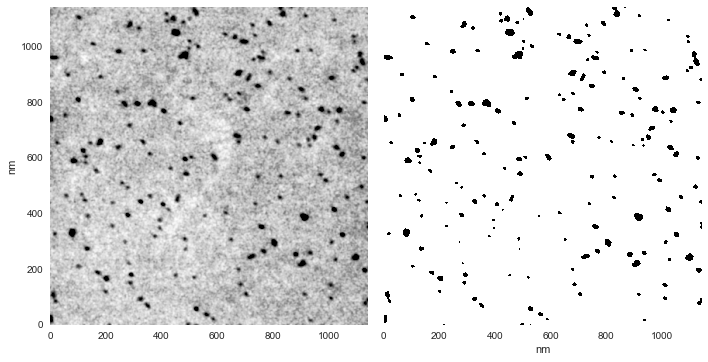

In [7]:
from scipy.ndimage import gaussian_filter
sI2 = gaussian_filter(I2, 5.)
M = sI2 > 5
N = M.shape[0]
l = N/876.*500
extent = [0, l, 0, l]
sf = 2
fig, (ax1, ax2) = subplots(ncols=2, figsize=(sf*5, sf*2.7), sharey=True)
ax1.imshow(sI2, vmax=10, extent=extent)
#ax2.imshow(sI2, vmax=10, extent=extent)
ax2.imshow(log10(10*M), cmap="binary", vmin=0, extent=extent)
ax1.set_aspect(1.)
ax2.set_aspect(1.)
ax2.set_xlabel("nm")
ax1.set_ylabel("nm")
ax2.set_xlabel("nm")
for ax in [ax1, ax2]:
    ax.set_frame_on(False)
tight_layout()

In [8]:
from scipy.ndimage import label
L, nL = label(M)

In [9]:
A = zeros(nL)
for i in range(nL):
    A[i] = (L == i+1).sum()
d = sqrt(A/pi)*2
# scale 500 nm = 876 pixel
d_nm = d/876.*500
# Save data for Johan
import h5py
with h5py.File("particles_rubisco_002.h5", "w") as f:
    f["particle_area"] = A
    f["particle_diameter"] = d
    f["particle_diameter_nm"] = d_nm

Text(0.5,0,'Diameter [nm]')

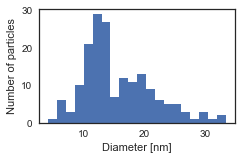

In [10]:
sf = 0.7
fig = figure(figsize=(5*sf,3*sf))
ax = fig.add_subplot(111)
H, d_edges, _= ax.hist(d_nm,20,lw=0)
d_centers = d_edges[:-1] +(d_edges[1]-d_edges[0])/2.

ax.set_ylabel("Number of particles")
ax.set_xlabel("Diameter [nm]")

Guess


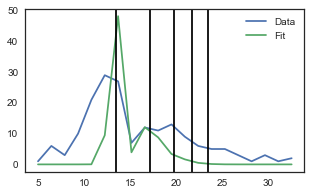

[ 1.55585112e+02  7.00000000e+20  1.38285612e+02  1.22633302e+01
  1.56557969e+00  1.91222943e+00  2.10934607e+00  1.99491524e+00
 -1.48846154e+04  3.19687350e+00]
Fit


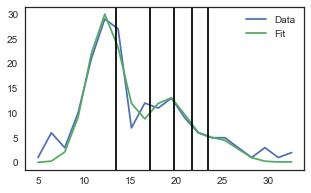

In [17]:
poisson_prob = lambda lam, k: exp(-lam)*lam**k/scipy.special.factorial(k)

droplet_V = lambda droplet_d: 4./3.*pi*(droplet_d*1E-9/2.)**3
lam = lambda conc_SI, droplet_d: conc_SI * droplet_V(droplet_d)

A0 = lambda conc_SI, droplet_d, sigma, k: poisson_prob(lam(conc_SI, droplet_d), k)/sigma
A0s = lambda conc_SI, droplet_d, sigmas, ks: [A0(conc_SI, droplet_d, sigma, k) for k, sigma in zip(ks, sigmas)]
    
f = lambda x, n, conc_SI, droplet_d, x0, a, sigmas: gaussians(
    x,
    A0s=A0s(
        conc_SI=conc_SI,
        droplet_d=droplet_d,
        sigmas=sigmas,
        ks=range(1, n+1)
    ),
    x0s=[(x0*k**(1/a)) for k in range(1, 1+n)],
    sigmas=sigmas,
)
_f = lambda x, n, p: p[0] * f(x, n, conc_SI=p[1], droplet_d=p[2], x0=p[3], a=p[4], sigmas=p[5:])

sigmas_init = [0.7, 0.8, 0.9, 1.0, 1.1]#, 1.3]#1.0, 1.0]#, 1.0, 1.0]
n = len(sigmas_init)
conc_SI_init = 7E20
A_init = 100
x0_init = 13.5
a_init = 2.9
droplet_d_init = 124.48319653
x0s_init = asarray([(x0_init*k**(1./a_init)) for k in range(1, 1+n)])
p_init = [A_init] + [conc_SI_init] + [droplet_d_init] + [x0_init] + [a_init] + sigmas_init

err = lambda p: ((H-_f(x=d_centers, n=n, p=p))**2).sum()

H_init = _f(x=d_centers, n=n, p=p_init)

print('Guess')
figure(figsize=(5,3))
plot(d_centers, H, label='Data')
plot(d_centers, H_init, label='Fit')
legend()
for x0 in x0s_init:
    axvline(x0, color='k')
show()
    
res = scipy.optimize.minimize(err, p_init)
p_fit = res.x
print(p_fit)

A_fit = p_fit[0]
conc_SI_fit = p_fit[1]
droplet_d_fit = p_fit[2]
x0_fit = p_fit[3]
a_fit = p_fit[4]
sigmas_fit = p_fit[5:]

x0s_fit = asarray([(x0_fit*k**(1./a_fit)) for k in range(1, 1+n)])

H_fit = _f(x=d_centers, n=n, p=res.x)

print('Fit')
figure(figsize=(5,3))
plot(d_centers, H, label='Data')
plot(d_centers, H_fit, label='Fit')
legend()
for x0 in x0s_init:
    axvline(x0, color='k')
show()

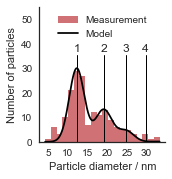

In [18]:
fig = figure(figsize=(2.5,2.5))
ax = fig.add_axes([0.25, 0.2, 0.7, 0.75])
H, d_edges, _= ax.hist(d_nm, 20, lw=0, color='C2', alpha=0.8, label='Measurement')
d_fine = linspace(d_edges[0], d_edges[-1], 1000)
H_fit_fine = _f(x=d_fine, n=n, p=res.x)
ax.plot(d_fine, H_fit_fine, color='k', label='Model')
#ax.legend(loc='upper center', ncol=1)
handles, labels = ax.get_legend_handles_labels()
# sort both labels and handles by labels
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
ax.legend(handles, labels, loc='upper center', ncol=1)
for x0, k in zip(x0s_fit, range(1, n+1)):
    if k >4:
        continue
    ax.text(x0, 36, k, ha='center', va='bottom')
    ax.axvline(x0, color='k', lw=1., ymin=0., ymax=32./50)
ax.set_ylabel("Number of particles")
ax.set_xlabel("Particle diameter / nm")
ax.set_xticks([5, 10, 15, 20, 25, 30])
ax.set_ylim(0, 55)
sns.despine()
savefig("../fig5c_em_rubusco_hist.png", dpi=300)

/Users/max.hantke/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()


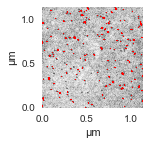

In [61]:
from scipy.ndimage import gaussian_filter
sI2 = gaussian_filter(I2, 5.)
M = sI2 > 5
N = M.shape[0]
l = N/876.*500
extent = [0, l, 0, l]
sf = 0.7
fig = figure(figsize=(2.5,2.))
ax = fig.add_axes([0.2, 0.25, 0.7, 0.7])
ax.imshow(sI2, vmax=10, extent=extent)
ax.imshow(log10(10*M), cmap="autumn_r", vmin=0, vmax=1, extent=extent)
ax.set_aspect(1.)
ax.set_xticks([0, 500, 1000])
ax.set_xticklabels(['0.0', '0.5', '1.0'])
ax.set_yticks([0, 500, 1000])
ax.set_yticklabels(['0.0', '0.5', '1.0'])
ax.set_xlabel(u"\u03bcm")
ax.set_ylabel(u"\u03bcm")
ax.set_frame_on(False)
savefig("../fig5b_em_rubusco_img.png", dpi=300)

In [109]:
a_fit

1.565577709298183